In [30]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2


import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
import utils
import plotting

from scipy import stats


import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

In [57]:
isorropia_df = './data/ISORROPIA_data.csv'

model = 'normal'
name = 'constant_SO4'
folder_path = '../../ISORROPIAIIStandalone/output/ISOOutput'

#numerical_noise1 = f'../../ISORROPIAIIStandalone/numerical_noise_check/NE_JJA_higherSO2_ISOOutput_numerical_noise.nc'
#numerical_noise2 = f'../../ISORROPIAIIStandalone/numerical_noise_check/NE_JJA_normal_ISOOutput_numerical_noise.nc'
#numerical_noise3 = f'../../ISORROPIAIIStandalone/numerical_noise_check/NE_JJA_lowerSO2_ISOOutput_numerical_noise.nc'

#ds_nn1 = utils.open_ISORROPIA(numerical_noise1, numerical_noise1, ['JJA', 'JJA'], 'NE', two_seasons = False) #actually just JJA, so only select that month
#ds_nn2 = utils.open_ISORROPIA(numerical_noise2, numerical_noise2, ['JJA', 'JJA'], 'NE', two_seasons = False) #actually just JJA, so only select that month
#ds_nn3 = utils.open_ISORROPIA(numerical_noise3, numerical_noise3, ['JJA', 'JJA'], 'NE', two_seasons = False) #actually just JJA, so only select that month


#ds_nn = xr.concat([ds_nn1, ds_nn2, ds_nn3], pd.Index(['high', 'normal', 'low'], name = 'SO2_level'))


ds_list = []
for region in ['MW','SW','NE','NW','SE']:
    DJF_path = f'{folder_path}_{region}_lat_lon_DJF_{model}_{name}.nc'
    JJA_path = f'{folder_path}_{region}_lat_lon_JJA_{model}_{name}.nc'
    ds = utils.open_ISORROPIA(DJF_path, JJA_path, ['DJF','JJA'], region)
    ds_list.append(ds)


ds_isorropia = xr.concat([ds for ds in ds_list], 
          pd.Index([ds.region_name for ds in ds_list], 
                   name='region_name'))


In [58]:
#convert to micrograms/m3
mw_dict = {'TNH4': 18.,
           'TNO3': 62.,
          'SO4Out': 96.,
          'GNO3Out': 63.,
          'TNH4Out': 18.,
          'NH3Out': 17.,
          'TNO3Out': 62.} #g/mol

for spec in mw_dict.keys():
    attrs = ds_isorropia[spec].attrs
    ds_isorropia[spec] = ds_isorropia[spec]*mw_dict[spec]*10e6
    attrs['units'] = 'μg m-3'
    ds_isorropia[spec].attrs.update(attrs)

#add in particulate matter by adjusting for hygroscopic growth and summing our total NO3, NH4 and SO4
ds_isorropia = ds_isorropia.assign(PM = 1.33*(ds_isorropia['TNO3Out']-ds_isorropia['GNO3Out']+ds_isorropia['TNH4Out'] - ds_isorropia['NH3Out']+ds_isorropia['SO4Out']))
ds_isorropia['PM'].attrs['units'] = 'μg m-3'
ds_isorropia['PM'].attrs['long_name'] = 'Total Inorganic PM'

#rename our coordinates
ds_isorropia.TNH4.attrs['long_name'] = 'Total Ammonium'
ds_isorropia.TNO3.attrs['long_name'] = 'Total NO3'

#### do the same to our numerical noise ds

#for spec in list(mw_dict.keys())[1:]:
  #  attrs = ds_nn[spec].attrs
  #  ds_nn[spec] = ds_nn[spec]*mw_dict[spec]*10e6
  #  attrs['units'] = 'μg m-3'
  #  ds_nn[spec].attrs.update(attrs)

#add in particulate matter by adjusting for hygroscopic growth and summing our total NO3, NH4 and SO4
#ds_nn = ds_nn.assign(PM = 1.33*(ds_nn['TNO3Out']-ds_nn['GNO3Out']+ds_nn['TNH4Out'] - ds_nn['NH3Out']+ds_nn['SO4Out']))
#ds_nn['PM'].attrs['units'] = 'μg m-3'
#ds_nn['PM'].attrs['long_name'] = 'Total Inorganic PM'

#rename our coordinates
#ds_nn.TNO3.attrs['long_name'] = 'Total NO3'

## 'Numerical Noise' to see the jumps that occur in ISORROPIA

NameError: name 'ds_nn' is not defined

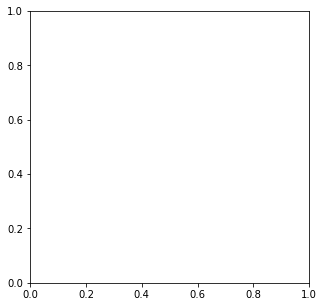

In [59]:
fig, ax = plt.subplots(1,1,figsize = [5,5])
for lev in ds_nn['SO2_level']:
    so4 = [np.round(ds_nn.sel(SO2_level = lev)['SO4Out'].values.squeeze().mean(), 2)]
    ds_nn.sel(SO2_level = lev, season = 'JJA').PM.plot(label = f'{lev.values} {so4}')
nh4 = ds_nn.sel(season = 'JJA').TNH4Out.values.squeeze().mean()
print('nh4 level ' + str(nh4))
plt.xlim([0,18])
plt.tight_layout()
plt.title(' ')
plt.legend(title = 'Sulfate level [ppb]')
plt.savefig('./Figures/numerical_noise_NE_JJA', dpi = 150, bbox_inches = 'tight')

## Import NIT, PM25, SO4, NO2 from observations and model

In [60]:
#dict for seasons
season_dict = {'DJF':[12,1,2],'JJA':[6,7,8]}

In [61]:
interp_EPA_df = pd.read_csv('./data/interp_EPA_df.csv', parse_dates = True)
EPA_obs_df = pd.read_csv('./data/EPA_obs_df.csv', parse_dates = True)
EPA_monthly_df = pd.read_csv('./data/EPA_monthly_obs_df.csv', parse_dates = True)
interp_EPA_df = interp_EPA_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

IMPROVE_obs_df = pd.read_csv('./data/IMPROVE_df.csv', parse_dates = True)
interp_IMPROVE_df = pd.read_csv('./data/interp_IMPROVE_df.csv', parse_dates = True)
IMPROVE_monthly_df = pd.read_csv('./data/IMPROVE_monthly_obs_df.csv', parse_dates = True)
interp_IMPROVE_df = interp_IMPROVE_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

#change to datetime
interp_EPA_df['date'] = pd.to_datetime(interp_EPA_df['date'])
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['date'], format='%Y%m%d')
EPA_monthly_df['date'] = pd.to_datetime(EPA_monthly_df['date'], format = '%Y%m%d')
IMPROVE_obs_df['date'] = pd.to_datetime(IMPROVE_obs_df['Date'], format = '%Y%m%d')
interp_IMPROVE_df['date'] = pd.to_datetime(interp_IMPROVE_df['date'])
IMPROVE_monthly_df['date'] = pd.to_datetime(IMPROVE_monthly_df['date'], format = '%Y%m%d')

#select only Lat and Lon on continental US
EPA_obs_df = EPA_obs_df.loc[(EPA_obs_df['Latitude'].between(24,50,inclusive = True)) & (EPA_obs_df['Longitude'].between(-130,-60,inclusive = True))]
EPA_monthly_df = EPA_monthly_df.loc[(EPA_monthly_df['Latitude'].between(24,50,inclusive = True)) & (EPA_monthly_df['Longitude'].between(-130,-60,inclusive = True))]
interp_EPA_df = interp_EPA_df.loc[(interp_EPA_df['latitude'].between(24,50,inclusive = True)) & (interp_EPA_df['longitude'].between(-130,-60,inclusive = True))]
IMPROVE_obs_df = IMPROVE_obs_df.loc[(IMPROVE_obs_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_obs_df['Longitude'].between(-130,-60,inclusive = True))]
interp_IMPROVE_df = interp_IMPROVE_df.loc[(interp_IMPROVE_df['latitude'].between(24,50,inclusive = True)) & (interp_IMPROVE_df['longitude'].between(-130,-60,inclusive = True))]
IMPROVE_monthly_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_monthly_df['Longitude'].between(-130,-60,inclusive = True))]

#change latitude
interp_IMPROVE_df = interp_IMPROVE_df.rename(columns = {'latitude':'Latitude','longitude':'Longitude'})
interp_EPA_df = interp_EPA_df.rename(columns = {'latitude':'Latitude','longitude':'Longitude'})

/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### CHANGE TO JUST CALCULATE VIA NIT, SO4, NH4 FOR THE INORGANIC PM

In [62]:
#modify the IMPROVE monthly df
IMPROVE_monthly_df['model_name'] = 'IMPROVE'

#create a dataframe with the inorganic PM from the obervations
PM_df = IMPROVE_monthly_df.loc[IMPROVE_monthly_df['species'] == 'PM25']
OC_df = IMPROVE_monthly_df.loc[IMPROVE_monthly_df['species'] == 'OC'] #### CHANGE TO JUST CALCULATE VIA NIT, SO4, NH4
inorganic_PM_IMPROVE_df = PM_df.merge(OC_df,
                              indicator=True,
                              how='outer', on = ['geometry','date','Latitude','Longitude', 'Region'])
inorganic_PM_IMPROVE_df['Arithmetic Mean'] = inorganic_PM_IMPROVE_df['Arithmetic Mean_x']- inorganic_PM_IMPROVE_df['Arithmetic Mean_y']
inorganic_PM_IMPROVE_df['species'] = 'inorganic_PM'
inorganic_PM_IMPROVE_df['model_name'] = 'IMPROVE'
inorganic_PM_IMPROVE_df = inorganic_PM_IMPROVE_df.dropna(axis = 0)

inorganic_PM_IMPROVE_df = inorganic_PM_IMPROVE_df.drop(columns = {'Arithmetic Mean_x','Arithmetic Mean_y','species_x','species_y','_merge','model_name_x','model_name_y'})


In [63]:

#join all dataframes
model_obs_df_1 = pd.concat([interp_IMPROVE_df, IMPROVE_monthly_df, inorganic_PM_IMPROVE_df])   # CONCATENATE

#find where the NIT data and PM data diverge and get rid of these readings in the PM data
PM_df = inorganic_PM_IMPROVE_df.loc[(inorganic_PM_IMPROVE_df['Region'] == 'NW_lat_lon') & (inorganic_PM_IMPROVE_df['species'] == 'inorganic_PM')]
NIT_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Region'] == 'NW_lat_lon') & (IMPROVE_monthly_df['species'] == 'NIT')]
comparison_df = NIT_df.merge(PM_df,
                              indicator=True,
                              how='outer', on = ['geometry','date'])
PM_to_delete = comparison_df[comparison_df['_merge'] == 'right_only'].dropna(axis = 1)
PM_to_delete = PM_to_delete.rename(columns = {'Arithmetic Mean_y':'Arithmetic Mean', 'Latitude_y':'Latitude', 'Longitude_y':'Longitude','species_y':'species','Region_y':'Region','annual_T_y':'annual_T','annual_RH_y':'annual_RH','model_name_y':'model_name'})
PM_to_delete = PM_to_delete.drop(columns = '_merge')

#drop these values from the dataframe
model_obs_df = pd.concat([model_obs_df_1, PM_to_delete]).drop_duplicates(keep=False)


In [66]:

#modify the PM to just be the inorganic PM form the model runs
for model in ['egrid','NEI2016','NEI2011','normal_model', 'nonuc_model']:
    for region in model_obs_df['Region'].unique():
        for season in season_dict.keys():
            model_obs_df.loc[
                (model_obs_df['species'] == 'PM25') & 
                (model_obs_df['model_name'] == model) & 
                (model_obs_df['Region'] == region) & 
                (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'] = 1.33* (
                model_obs_df.loc[(model_obs_df['species'] == 'NIT') & 
                        (model_obs_df['model_name'] == model) & 
                        (model_obs_df['Region'] == region) & 
                        (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'].values + 
                model_obs_df.loc[(model_obs_df['species'] == 'SO4') & 
                    (model_obs_df['model_name'] == model) & 
                    (model_obs_df['Region'] == region) & 
                    (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'].values +
                model_obs_df.loc[(model_obs_df['species'] == 'NH4') & 
                    (model_obs_df['model_name'] == model) & 
                    (model_obs_df['Region'] == region) & 
                    (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'].values)

In [67]:

#normal, egrid, nei merge
PM_df = interp_EPA_df.loc[interp_EPA_df['species'] == 'PM25']
no2_df = interp_EPA_df.loc[interp_EPA_df['species'] == 'NO2']

comparison_EPA_df = no2_df.merge(PM_df,
                              indicator=True,
                              how='outer', on = ['Latitude','Longitude','date', 'Region', 'model_name'])

to_delete_nox = comparison_EPA_df[comparison_EPA_df['_merge'] == 'left_only']
to_delete_nox = to_delete_nox.rename(columns = {'Arithmetic Mean_x':'Arithmetic Mean',
                                              'species_x':'species'})
to_delete_nox = to_delete_nox.drop(columns = ['_merge', 'Arithmetic Mean_y', 'species_y'])

to_delete_PM = comparison_EPA_df[comparison_EPA_df['_merge'] == 'right_only']
to_delete_PM = to_delete_PM.rename(columns = {'Arithmetic Mean_y':'Arithmetic Mean',
                                              'species_y':'species'})
to_delete_PM = to_delete_PM.drop(columns = ['_merge', 'Arithmetic Mean_x', 'species_x'])

interp_EPA_df = pd.concat([interp_EPA_df, to_delete_PM, to_delete_nox]).drop_duplicates(keep=False)


In [52]:
from scipy.spatial.distance import cdist

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]


df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

df1['point'] = [(x, y) for x,y in zip(df1['Lat'], df1['Lon'])]
df2['point'] = [(x, y) for x,y in zip(df2['Lat'], df2['Lon'])]

df2['closest'] = [closest_point(x, list(df1['point'])) for x in df2['point']]
df2['zone'] = [match_value(df1, 'point', x, 'Zone') for x in df2['closest']]


NameError: name 'data1' is not defined

### Plot PM2.5 vs Nitrate and NOx

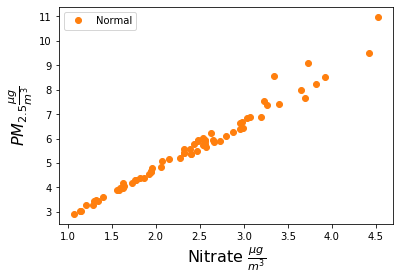

In [71]:
##plot the nitrate and pm2.5
a = model_obs_df.loc[
    (model_obs_df['species'] == 'PM25') & (model_obs_df['Region'] == 'NE_lat_lon') & 
    (model_obs_df['model_name'] == 'normal_model') & (model_obs_df['date'].dt.month.isin(season_dict['DJF']))]['Arithmetic Mean']


b = model_obs_df.loc[
    (model_obs_df['species'] == 'NIT') & (model_obs_df['Region'] == 'NE_lat_lon') & 
    (model_obs_df['model_name'] == 'normal_model') & (model_obs_df['date'].dt.month.isin(season_dict['DJF']))]['Arithmetic Mean']
slope, intercept, r_value, p_value, std_err = stats.linregress(b,a)
plt.plot(b,a, 'C1o', label = 'Normal')

#a2 = model_obs_df.loc[
 #   (model_obs_df['species'] == 'PM25') & (model_obs_df['Region'] == 'NE_lat_lon') & 
 #   (model_obs_df['model_name'] == 'nonuc_model') & (model_obs_df['date'].dt.month.isin(season_dict['DJF']))]['Arithmetic Mean']


#b2 = model_obs_df.loc[
#    (model_obs_df['species'] == 'NIT') & (model_obs_df['Region'] == 'NE_lat_lon') & 
 #   (model_obs_df['model_name'] == 'nonuc_model') & (model_obs_df['date'].dt.month.isin(season_dict['DJF']))]['Arithmetic Mean']

#plt.plot(b2,a2, 'C0s', label = 'No Nuclear')
plt.ylabel(r'$PM_{2.5} \frac{\mu g}{m^3}$', fontsize = 16)
plt.xlabel(r'Nitrate $\frac{\mu g}{m^3}$', fontsize = 16)
plt.legend()
#slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(b2,a2)
#plt.savefig('./Figures/dnit_dpm.png', bbox_inches = 'tight',dpi = 150)

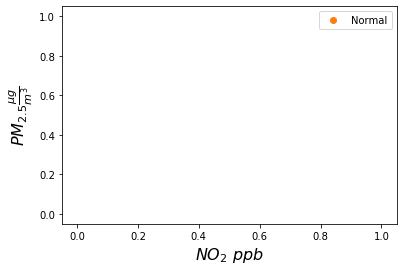

In [73]:
### plot the nox and pm2.5
a = interp_EPA_df.loc[
    (interp_EPA_df['species'] == 'PM25') & (interp_EPA_df['Region'] == 'NE_lat_lon') & 
    (interp_EPA_df['model_name'] == 'MODEL') & (interp_EPA_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']


b = interp_EPA_df.loc[
    (interp_EPA_df['species'] == 'NO2') & (interp_EPA_df['Region'] == 'NE_lat_lon') & 
    (interp_EPA_df['model_name'] == 'MODEL') & (interp_EPA_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']
#slope, intercept, r_value, p_value, std_err = stats.linregress(b,a)
plt.plot(b,a, 'C1o', label = 'Normal')

#a2 = interp_EPA_df.loc[
   # (interp_EPA_df['species'] == 'PM25') & (interp_EPA_df['Region'] == 'NE_lat_lon') & 
    #(interp_EPA_df['model_name'] == 'nonuc') & (interp_EPA_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']


#b2 = interp_EPA_df.loc[
   # (interp_EPA_df['species'] == 'NO2') & (interp_EPA_df['Region'] == 'NE_lat_lon') & 
    #(interp_EPA_df['model_name'] == 'nonuc') & (interp_EPA_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']

#plt.plot(b2,a2, 'C0s', label = 'No Nuclear')
plt.ylabel(r'$PM_{2.5} \frac{\mu g}{m^3}$', fontsize = 16)
plt.xlabel(r'$NO_2\ ppb$', fontsize = 16)
plt.legend()
#slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(b2,a2)
#plt.savefig('./Figures/dnit_dpm.png', bbox_inches = 'tight',dpi = 150)

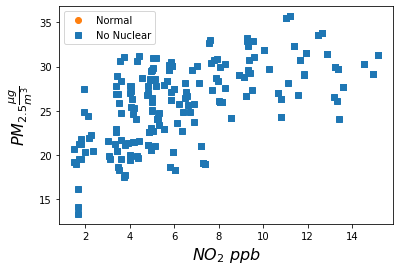

In [281]:
### plot the nox and pm2.5
a = interp_EPA_df.loc[
    (interp_EPA_df['species'] == 'PM25') & (interp_EPA_df['Region'] == 'NE_lat_lon') & 
    (interp_EPA_df['model'] == 'MODEL') & (interp_EPA_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']


b = interp_EPA_df.loc[
    (interp_EPA_df['species'] == 'NO2') & (interp_EPA_df['Region'] == 'NE_lat_lon') & 
    (interp_EPA_df['model'] == 'MODEL') & (interp_EPA_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']
#slope, intercept, r_value, p_value, std_err = stats.linregress(b,a)
plt.plot(b,a, 'C1o', label = 'Normal')

a2 = interp_EPA_nonuc_df.loc[
    (interp_EPA_nonuc_df['species'] == 'PM25') & (interp_EPA_nonuc_df['Region'] == 'NE_lat_lon') & 
    (interp_EPA_nonuc_df['model'] == 'nonuc') & (interp_EPA_nonuc_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']


b2 = interp_EPA_nonuc_df.loc[
    (interp_EPA_nonuc_df['species'] == 'NO2') & (interp_EPA_nonuc_df['Region'] == 'NE_lat_lon') & 
    (interp_EPA_nonuc_df['model'] == 'nonuc') & (interp_EPA_nonuc_df['date'].dt.month.isin(season_dict['JJA']))]['Arithmetic Mean']

plt.plot(b2,a2, 'C0s', label = 'No Nuclear')
plt.ylabel(r'$PM_{2.5} \frac{\mu g}{m^3}$', fontsize = 16)
plt.xlabel(r'$NO_2\ ppb$', fontsize = 16)
plt.legend()
#slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(b2,a2)
#plt.savefig('./Figures/dnit_dpm.png', bbox_inches = 'tight',dpi = 150)

In [49]:
#calculate the maximum difference in nitrate, from there look at whether or not this * the bias in nitrate would lead to a difference in PM
nonuc_NIT = model_obs_df.loc[
    (model_obs_df['species'] == 'NIT') & (model_obs_df['Region'] == 'NE_lat_lon') & 
    (model_obs_df['model'] == 'nonuc') & (model_obs_df['date'].dt.month.isin(season_dict['DJF']))]['Arithmetic Mean']

normal_NIT = model_obs_df.loc[
    (model_obs_df['species'] == 'NIT') & (model_obs_df['Region'] == 'NE_lat_lon') & 
    (model_obs_df['model'] == 'MODEL') & (model_obs_df['date'].dt.month.isin(season_dict['DJF']))]['Arithmetic Mean']

max_dif_NIT = nonuc_NIT.max() - normal_NIT.max()
max_dif_NIT

## ISORROPIA Plots with Data on top

../plotting.py:434: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


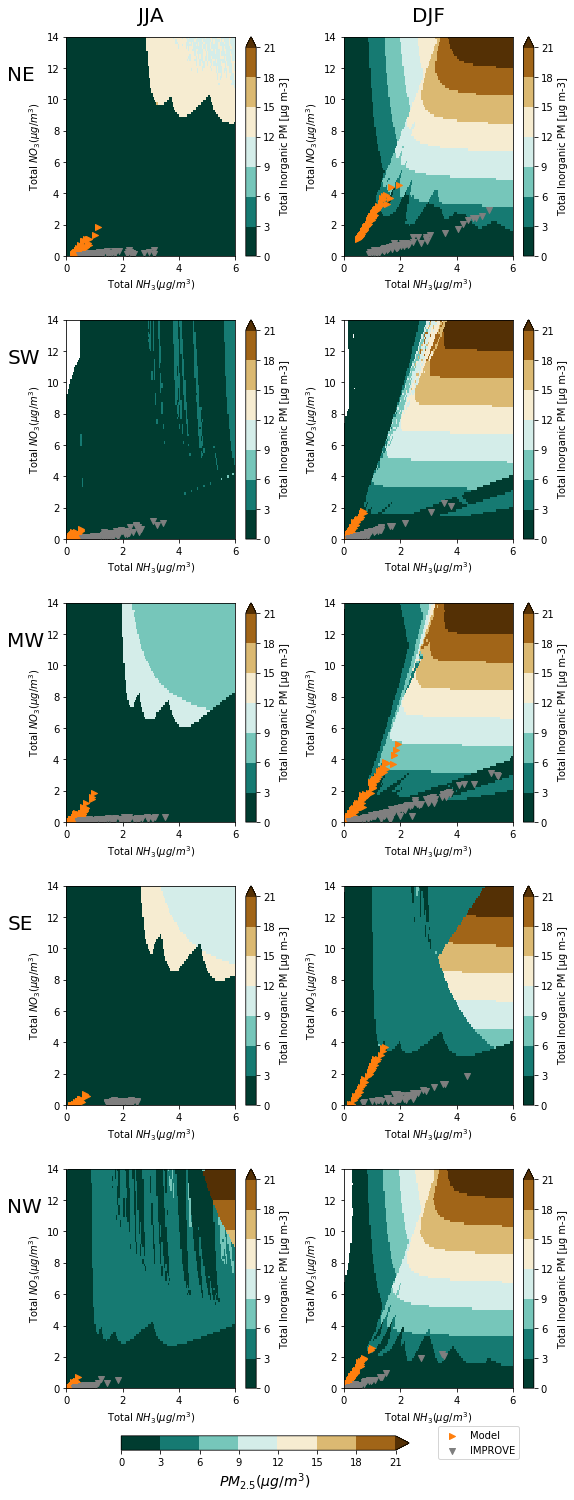

In [77]:
plotting.isorropia_obs_model_plot(model_obs_df, ds_isorropia, vmin = 0, vmax = 24, spacing = 3)
#plt.savefig('./Figures/isorropia_obs_plot.png', bbox_inches = 'tight', dpi = 150)